# **Modèles épidémiologiques**
## MDI230 - Files d'attente 
## Fait par : **Samia Abrik**

In [113]:
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import curve_fit
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(palette="colorblind", style="darkgrid")

## **Le système déterministe SIR**

Une population de $N$ individus, partitionné en trois catégories :

- les susceptibles : ceux qui peuvent être contaminés,
- les infectieux : ceux qui sont contaminés,
- les retirés : ceux qui ne sont plus contaminables soient parce que décédés, soient parce que guéris et immunisés.

On note $S(t)$, $I(t)$ et $R(t)$ les nombres de susceptibles, infectieux et retirés à l’instant t. On a évidemment $ S(t) + I(t) + R(t) = N $.

A l’instant initial, il y a un seul infecté : $ S(0) = N-1, I(0) = 1, R(0) = 0 $ 

Le système d'équations différentielles qui régit le modèle est :
$$
\begin{align*}
s'(t) &= -\beta s(t) i(t) \\
i'(t) &= \beta s(t) i(t) - \gamma i(t) \\
r'(t) &= \gamma i(t)
\end{align*}
$$
sous la contrainte $s(t) \geq 0, i(t) \geq 0, r(t) \geq 0$. 


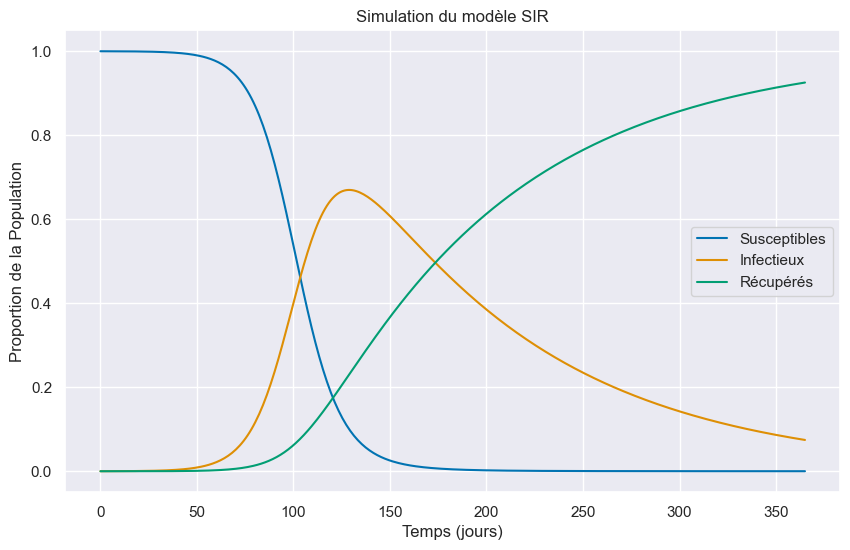

In [104]:
def model_sir(y, t, beta, gamma, N):
    S, I, R = y
    dSdt = -beta * S * I / N        # division par N pour normaliser les valeurs
    dIdt = beta * S * I / N - gamma * I 
    dRdt = gamma * I 
    return [dSdt, dIdt, dRdt]

def simulate_sir(S0, I0, R0, beta, gamma, T):
    """
    Simule le modèle SIR.
    
    Args:
        S0 (int): Nombre initial de susceptibles.
        I0 (int): Nombre initial d'infectieux.
        R0 (int): Nombre initial de récupérés.
        beta (float): Taux de transmission.
        gamma (float): Taux de récupération.
        T (int): Nombre total de jours à simuler.

    Returns:
        t, S, I, R:  Les vecteurs de temps, de susceptibles, d'infectieux et de récupérés.
    """
    t = np.linspace(0, T, T)  # Création d'un espace de temps de 0 à T jours
    y0 = [S0, I0, R0]  # Conditions initiales
    # Intégration des équations du modèle SIR au fil du temps
    ret = odeint(model_sir, y0, t, args=(beta, gamma, N))
    S, I, R = ret.T  # Transposition pour séparer les résultats
    return t, S, I, R

# Paramètres de simulation
N = 10000 
I0 = 1
S0 = N-1
R0 = 0
beta = 0.1 # Taux de transmission
gamma = 0.01 # Taux de récupération
T = 365 # Nombre de jours à simuler (1 an)

t, S, I, R = simulate_sir(S0, I0, R0, beta, gamma, T)

# Affichage des résultats
plt.figure(figsize=(10, 6))
plt.plot(t, S/N, label='Susceptibles') # Normalisation par N pour avoir des proportions
plt.plot(t, I/N, label='Infectieux')
plt.plot(t, R/N, label='Récupérés')
plt.xlabel('Temps (jours)')
plt.ylabel('Proportion de la Population')
plt.title('Simulation du modèle SIR')
plt.legend()
plt.grid(True)
plt.show()


## **Le processus de Markov**

Dans le modèle markovien, $\beta$ représente le taux de rencontres que ce soit avec des susceptibles, des infectés ou des retirés. Dans le cas où la durée d’infection $\mathcal{I}$ est exponentiellement distribuée de moyenne $1/\gamma$, le processus $X =
(S, I, R)$ est un processus de Markov. Il admet les transitions suivantes:
$$
\begin{align*}
(s,i,r) &\longrightarrow (s-1,i+1,r) &\text{au taux} \quad \beta N^{-1}i s \mathbf{1}_{\{s>0\}} \\
        &\longrightarrow (s,i-1,r+1) &\text{au taux} \quad \gamma i \mathbf{1}_{\{i>0\}}
\end{align*}
$$

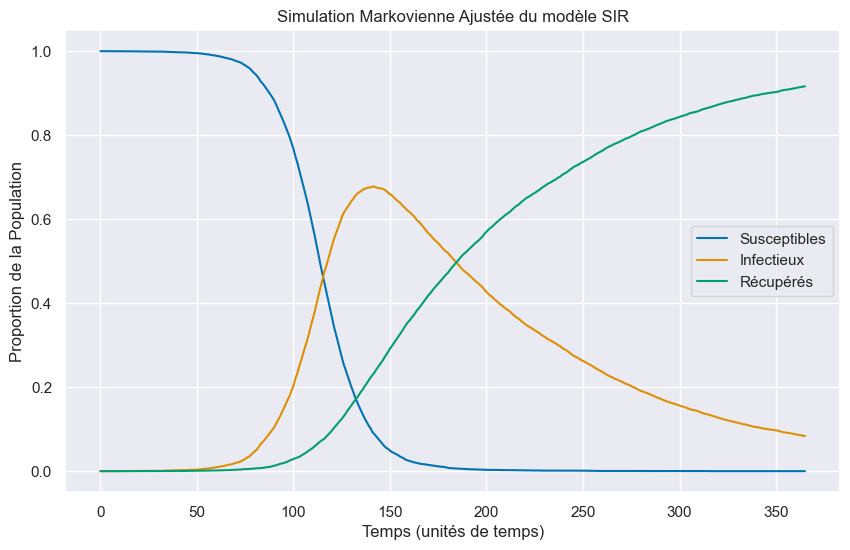

In [105]:
def markov_sir_simulation(N, I0, beta, gamma, T):
    """
    Simule une épidémie en utilisant un modèle SIR markovien ajusté selon les taux précisés.
    
    Args:
        N (int): Population totale.
        I0 (int): Nombre initial d'infectés.
        beta (float): Taux de transmission par contact.
        gamma (float): Taux de récupération.
        T (int): Durée totale de la simulation (en unités de temps).
    
    Returns:
        S (list), I (list), R (list): Historiques des nombres de susceptibles, infectieux et retirés.
    """
    S = [N - I0]
    I = [I0]
    R = [0]
    
    for time in range(1, T + 1):
        if S[-1] > 0 and I[-1] > 0:
            infection_rate = (beta / N) * I[-1] * S[-1]
            new_infections = np.random.poisson(infection_rate)
        else:
            new_infections = 0

        if I[-1] > 0:
            recovery_rate = gamma * I[-1]
            new_recoveries = np.random.poisson(recovery_rate)
        else:
            new_recoveries = 0

        # Assurer que les transitions ne dépassent pas les populations disponibles
        new_infections = min(new_infections, S[-1])
        new_recoveries = min(new_recoveries, I[-1])

        # Mise à jour des compartiments
        S.append(S[-1] - new_infections)
        I.append(I[-1] + new_infections - new_recoveries)
        R.append(R[-1] + new_recoveries)

    return np.array(S), np.array(I), np.array(R)

# Paramètres de simulation
N = 10000
I0 = 1
beta = 0.1 
gamma = 0.01  
T = 365 # Nombre de jours à simuler (1 an)

S, I, R = markov_sir_simulation(N, I0, beta, gamma, T)

# Affichage des résultats
plt.figure(figsize=(10, 6))
plt.plot(S/N, label='Susceptibles')
plt.plot(I/N, label='Infectieux')
plt.plot(R/N, label='Récupérés')
plt.title('Simulation Markovienne Ajustée du modèle SIR')
plt.xlabel('Temps (unités de temps)')
plt.ylabel('Proportion de la Population')
plt.legend()
plt.grid(True)
plt.show()

Puisque on a pris une population assez large $(=10000)$, et en utilisant les mêmes paramètres $\beta$ et $\gamma$ et les mêmes conditions initiales, on trouve pratiquement le même graphique que celui obtenu avec le modèle déterministe. On retrouve donc que le modèle déterministe donné par le système (SIR) est la limite du modèle markovien.

## **Couple ($\beta$,$\gamma$) où tout le monde est retité sur le long terme**

On pose $R_0=\beta/\gamma$. La population de "retirés" finale, notée $r_{\infty}$ satisfait l'équation :
$$ 1-r_{\infty}=s(0)e^{-R_0 r_{\infty}}$$
Si tout le monde est retiré sur le long terme, alors $r_{\infty}=1$ et donc $e^{-R_0}$ tend vers $0$. $R_0$ doit tendre vers l'infini pour que cela soit vrai.\\
Les couples ($\beta$,$\gamma$) où tout le monde est retité sur le long terme sont les couples tels que $\beta >> \gamma$.

Exemple de couple ($\beta$,$\gamma$) :

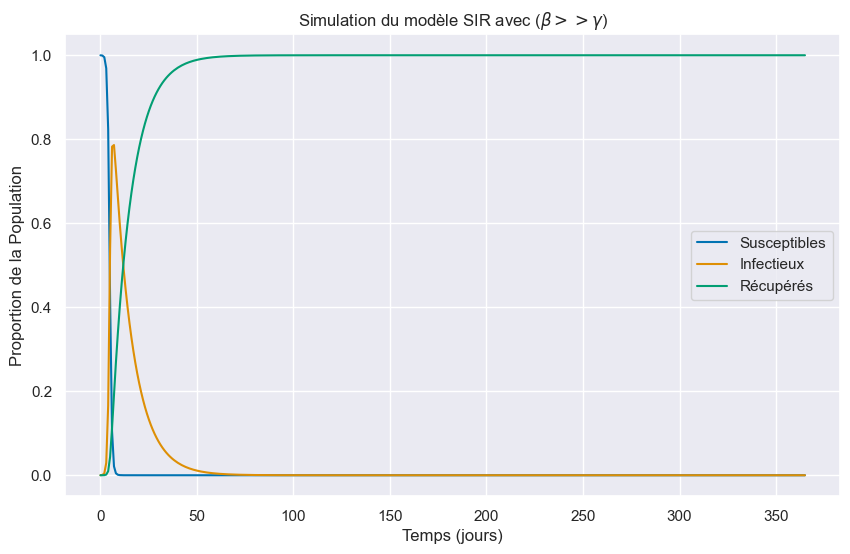

In [106]:
# Paramètres de simulation
N = 10000
I0 = 1
S0 = N-1
R0 = 0
beta = 2
gamma = 0.1 
T = 365 # Nombre de jours à simuler (1 an)

t, S, I, R = simulate_sir(S0, I0, R0, beta, gamma, T)

# Affichage des résultats
plt.figure(figsize=(10, 6))
plt.plot(t, S/N, label='Susceptibles') # Normalisation par N pour avoir des proportions
plt.plot(t, I/N, label='Infectieux')
plt.plot(t, R/N, label='Récupérés')
plt.xlabel('Temps (jours)')
plt.ylabel('Proportion de la Population')
plt.title(r'Simulation du modèle SIR avec ($\beta >> \gamma$)')
plt.legend()
plt.grid(True)
plt.show()

## **Couple ($\beta$,$\gamma$) où il reste une partie susceptible et une autre retirée**

S'il y a une partie de la population qui reste susceptible et une autre qui est retirée, $r_{\infty}$ est inférieur à $1$ et d'après l'équation précédente, et en considérant que $s(0)=1$ puisque dans nos simulation on choisit $S_0=N-1$ :
$$R_0=\frac{-log(1-r_{\infty})}{r_{\infty}} $$
Donc on peut choisir les couples ($\beta$,$\gamma$) tels que $\beta = \frac{-log(1-r_{\infty})}{r_{\infty}} \gamma$. 

Par exemple, si on choisit la moitié de la population est retirée $r_{\infty}=1/2$, on obtient $\beta = 2 log(2) \gamma$

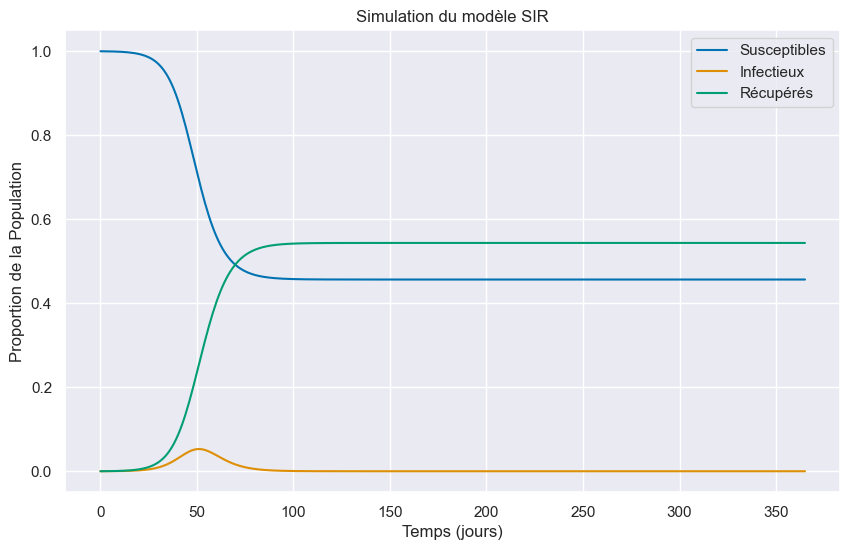

In [107]:
# Paramètres de simulation
N = 10000
I0 = 1
S0 = N-1
R0 = 0
beta = 0.5
gamma = 1/2*np.log(2) 
T = 365 # Nombre de jours à simuler (1 an)

t, S, I, R = simulate_sir(S0, I0, R0, beta, gamma, T)

# Affichage des résultats
plt.figure(figsize=(10, 6))
plt.plot(t, S/N, label='Susceptibles') # Normalisation par N pour avoir des proportions
plt.plot(t, I/N, label='Infectieux')
plt.plot(t, R/N, label='Récupérés')
plt.xlabel('Temps (jours)')
plt.ylabel('Proportion de la Population')
plt.title(r'Simulation du modèle SIR')
plt.legend()
plt.grid(True)
plt.show()

## **Convergence du processus de Markov renormalisé vers la solution du système déterministe**

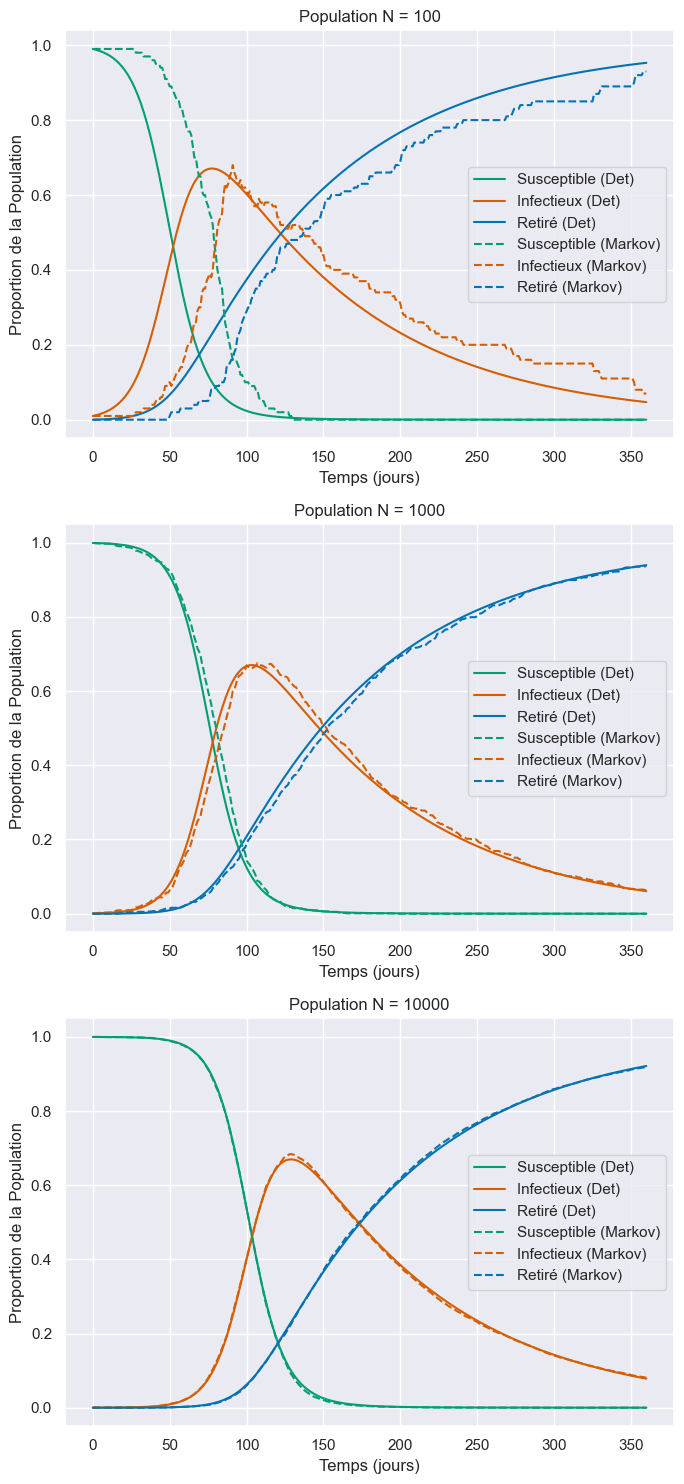

In [108]:
# Paramètres
N_values = [100, 1000, 10000]  # Différentes tailles de population
I0 = 1
beta = 0.1
gamma = 0.01
T = 360

# Tracer les résultats
plt.figure(figsize=(7, 15))

for i, N in enumerate(N_values, 1):
    S0 = N - I0
    R0 = 0
    
    # Modèle déterministe
    t_det, S_det, I_det, R_det = simulate_sir(S0, I0, R0, beta, gamma, T)
    
    # Modèle markovien
    S_mar, I_mar, R_mar = markov_sir_simulation(N, I0, beta, gamma, T)
    
    plt.subplot(len(N_values), 1, i)
    plt.plot(t_det, S_det/N, 'g', label='Susceptible (Det)')
    plt.plot(t_det, I_det/N, 'r', label='Infectieux (Det)')
    plt.plot(t_det, R_det/N, 'b', label='Retiré (Det)')
    plt.plot(np.arange(T + 1), S_mar/N, 'g--', label='Susceptible (Markov)')
    plt.plot(np.arange(T + 1), I_mar/N, 'r--', label='Infectieux (Markov)')
    plt.plot(np.arange(T + 1), R_mar/N, 'b--', label='Retiré (Markov)')
    plt.title(f'Population N = {N}')
    plt.xlabel('Temps (jours)')
    plt.ylabel('Proportion de la Population')
    plt.legend()

plt.tight_layout()
plt.show()


## **Estimation des paramètres pour des données de Santé Publique France**

In [112]:
df = pd.read_csv('donnees-covid.csv', sep=';')
df.head()

,dep,jour,incid_hosp,incid_rea,incid_dc,incid_rad
0,1,2020-03-19,1,0,0,0
1,1,2020-03-20,0,0,0,1
2,1,2020-03-21,3,0,0,0
3,1,2020-03-22,3,1,0,1
4,1,2020-03-23,14,1,0,5


Définition des variables du modèle:

- Infectés (I) : La somme des hospitalisations et des admissions en réanimation.
- Rétablis (R) : La somme des décès et des retournés à la maison.
- Susceptibles (S) : Nous estimons le nombre de susceptibles en soustrayant le nombre d'infectés et de rétablis de la population totale hypothétique du département.

Pour estimer $\beta$ et $\gamma$, on peut utiliser une approche de minimisation des moindres carrés pour ajuster le modèle SIR aux données épidémiologiques réelles.

In [135]:
# Choisir un département ('75' par exemple pour Paris)
dept_data = df[df['dep'] == '75']
N = 600  

# Aggrégation des données par jour
daily_data = dept_data.groupby('jour').sum().reset_index()

# Définir les variables pour le modèle SIR
I = daily_data['incid_hosp'] + daily_data['incid_rea'] 
R = daily_data['incid_dc'] + daily_data['incid_rad']  
S = np.maximum(0, N - I - R)  

# Conditions initiales
S0, I0, R0 = S.iloc[0], I.iloc[0], R.iloc[0]

def fit_sir(t, beta, gamma, S0, I0, R0, N):
    return odeint(model_sir, [S0, I0, R0], t, args=(beta, gamma, N))

# Temps (indice des jours)
t = np.arange(len(daily_data))

# Ajustement du modèle aux données
params, cov = curve_fit(lambda t, beta, gamma: fit_sir(t, beta, gamma, S0, I0, R0, N)[:, 1],  t, I.values, p0=[0.001, 0.1])

beta_est, gamma_est = params
print("Estimation de beta:", beta_est)
print("Estimation de gamma:", gamma_est)

Estimation de beta: 0.32891235834509613
Estimation de gamma: 0.04745234779655626


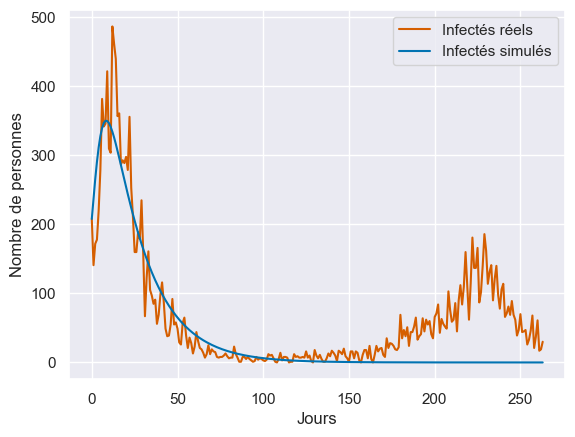

In [136]:
# Simulation avec les paramètres estimés pour visualisation
sol = fit_sir(t, beta_est, gamma_est, S0, I0, R0, N)

# Visualisation des résultats
plt.plot(t, I, 'r', label='Infectés réels')
plt.plot(t, sol[:, 1], 'b', label='Infectés simulés')
plt.xlabel('Jours')
plt.ylabel('Nombre de personnes')
plt.legend()
plt.show()

On remarque que notre modèle simulé correspond un peu près aux données analysées.